In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications import VGG16, MobileNetV2
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout, GlobalAveragePooling2D, BatchNormalization, Rescaling, Activation, concatenate, Conv2DTranspose
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

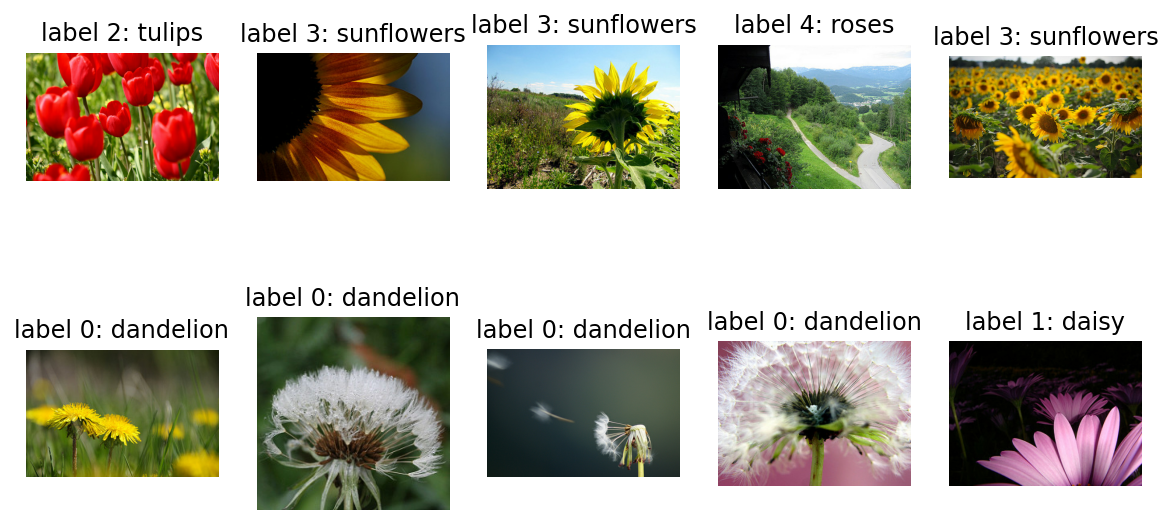

In [3]:
plt.figure(figsize=(10, 5))

get_label_name = metadata.features['label'].int2str

for idx, (image, label) in enumerate(train_ds.take(10)):
    plt.subplot(2, 5, idx+1)
    plt.imshow(image)
    plt.title(f'label {label}: {get_label_name(label)}')
    plt.axis('off')

In [4]:
batch_size = 64
IMG_SIZE = 360

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.3)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    return image, label

def resize_and_rescale(image, label):
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    return image, label

# 데이터셋 전처리 적용
train_ds = train_ds.map(resize_and_rescale, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.cache()
train_ds = train_ds.shuffle(1000)
train_ds = train_ds.map(augment, num_parallel_calls=tf.data.AUTOTUNE) # 데이터 증강 적용
train_ds = train_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

val_ds = val_ds.map(resize_and_rescale, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.batch(batch_size).cache().prefetch(tf.data.AUTOTUNE)

test_ds = test_ds.map(resize_and_rescale, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.batch(batch_size).cache().prefetch(tf.data.AUTOTUNE)


## Modeling

### Baseline

In [5]:
# 입력 레이어 정의

model = Sequential([
  layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(5)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Callbacks 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, min_lr=0.0001)

# 모델 훈련
EPOCHS = 50
baseline_history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=[early_stopping, model_checkpoint, reduce_lr])

Epoch 1/50
46/46 [==============================] - 17s 213ms/step - loss: 130.1161 - accuracy: 0.2939 - val_loss: 1.6053 - val_accuracy: 0.3460

Epoch 00001: val_loss improved from inf to 1.60532, saving model to best_model.h5
Epoch 2/50
46/46 [==============================] - 6s 123ms/step - loss: 1.5340 - accuracy: 0.3658 - val_loss: 1.4876 - val_accuracy: 0.4196

Epoch 00002: val_loss improved from 1.60532 to 1.48758, saving model to best_model.h5
Epoch 3/50
46/46 [==============================] - 5s 112ms/step - loss: 1.3611 - accuracy: 0.4523 - val_loss: 1.3409 - val_accuracy: 0.4714

Epoch 00003: val_loss improved from 1.48758 to 1.34094, saving model to best_model.h5
Epoch 4/50
46/46 [==============================] - 5s 112ms/step - loss: 1.1559 - accuracy: 0.5674 - val_loss: 1.2603 - val_accuracy: 0.5477

Epoch 00004: val_loss improved from 1.34094 to 1.26026, saving model to best_model.h5
Epoch 5/50
46/46 [==============================] - 5s 113ms/step - loss: 0.9983 - ac

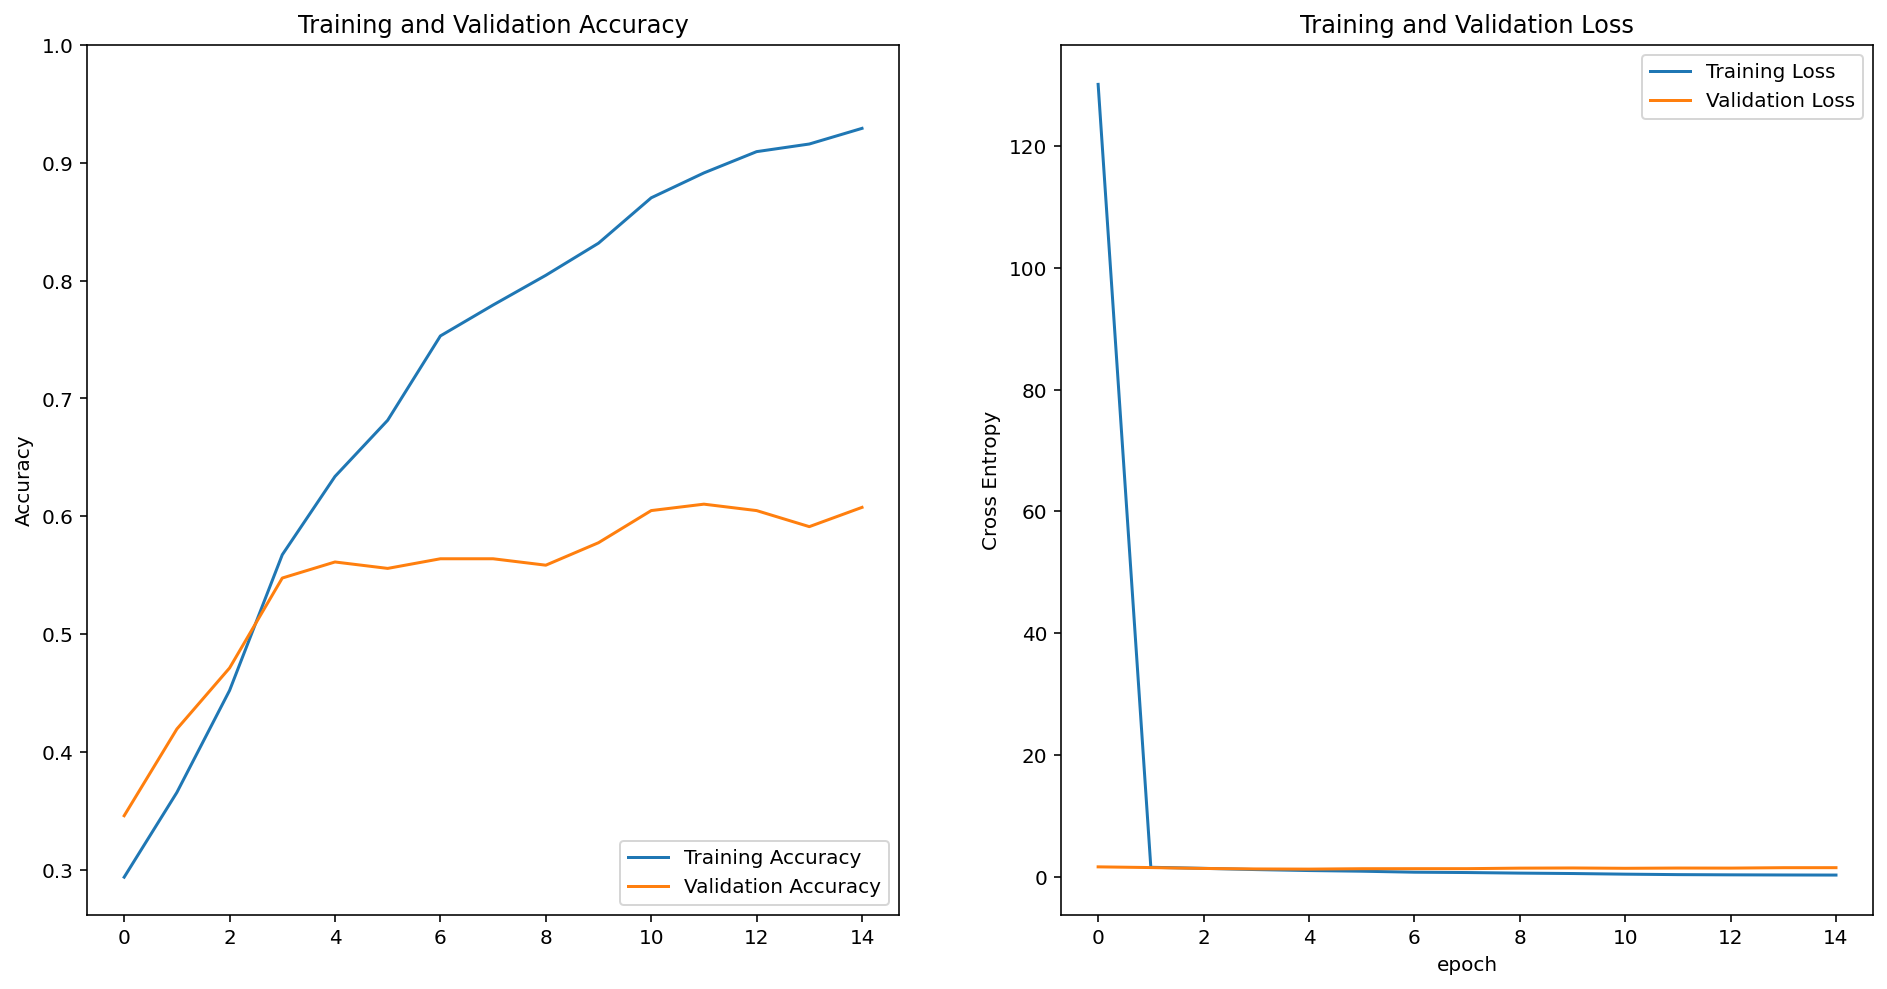

In [6]:
baseline_acc = baseline_history.history['accuracy']
baseline_val_acc = baseline_history.history['val_accuracy']

baseline_loss = baseline_history.history['loss']
baseline_val_loss = baseline_history.history['val_loss']

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(baseline_acc, label='Training Accuracy')
plt.plot(baseline_val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(baseline_loss, label='Training Loss')
plt.plot(baseline_val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [7]:
baseline_test_loss, baseline_test_acc = model.evaluate(test_ds)

6/6 [==============================] - 1s 86ms/step - loss: 1.3018 - accuracy: 0.4932


### ResNet50 (Transfer Learning)

In [8]:
# 사전 훈련된 ResNet50 모델 로드. include_top=False로 설정하여 네트워크 최상위 층을 포함하지 않음
input_layer = Input(shape=(IMG_SIZE, IMG_SIZE, 3))

base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=input_layer)

# 모델의 모든 층을 학습 불가능하게 설정
for layer in base_model.layers:
    layer.trainable = False

# Global Average Pooling 층 및 추가 층을 쌓음, 여기에 Batch Normalization 적용
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x) 
x = Dropout(0.25)(x) 
predictions = Dense(5, activation='softmax')(x)

# 최종 모델 구성
model = Model(inputs=input_layer, outputs=predictions)

# 모델 컴파일
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 모델 요약 출력
model.summary()

# Callbacks 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, min_lr=0.0001)

# 모델 훈련
EPOCHS = 50
resnet50_history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=[early_stopping, model_checkpoint, reduce_lr])  # callback 리스트 추가


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 360, 360, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 366, 366, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 180, 180, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 180, 180, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/50
46/46 [==============================] - 24s 517ms/step - loss: 0.2565 - accuracy: 0.9070 - val_loss: 0.4885 - val_accuracy: 0.8365

Epoch 00002: val_loss improved from 0.60635 to 0.48847, saving model to best_model.h5
Epoch 3/50
46/46 [==============================] - 24s 513ms/step - loss: 0.1923 - accuracy: 0.9315 - val_loss: 0.4170 - val_accuracy: 0.8747

Epoch 00003: val_loss improved from 0.48847 to 0.41704, saving model to best_model.h5
Epoch 4/50
46/46 [==============================] - 24s 519ms/step - loss: 0.1363 - accuracy: 0.9496 - val_loss: 0.3049 - val_accuracy: 0.9019

Epoch 00004: val_loss improved from 0.41704 to 0.30486, saving model to best_model.h5
Epoch 5/50
46/46 [==============================] - 24s 518ms/step - loss: 0.1142 - accuracy: 0.9571 - val_loss: 0.3042 - val_accuracy: 0.8910

Epoch 00005: val_loss improved from 0.30486 to 0.30422, saving model to best_model.h5
Epoch 6/50
46/46 [==============================] - 24s 513ms/step - loss: 0.104

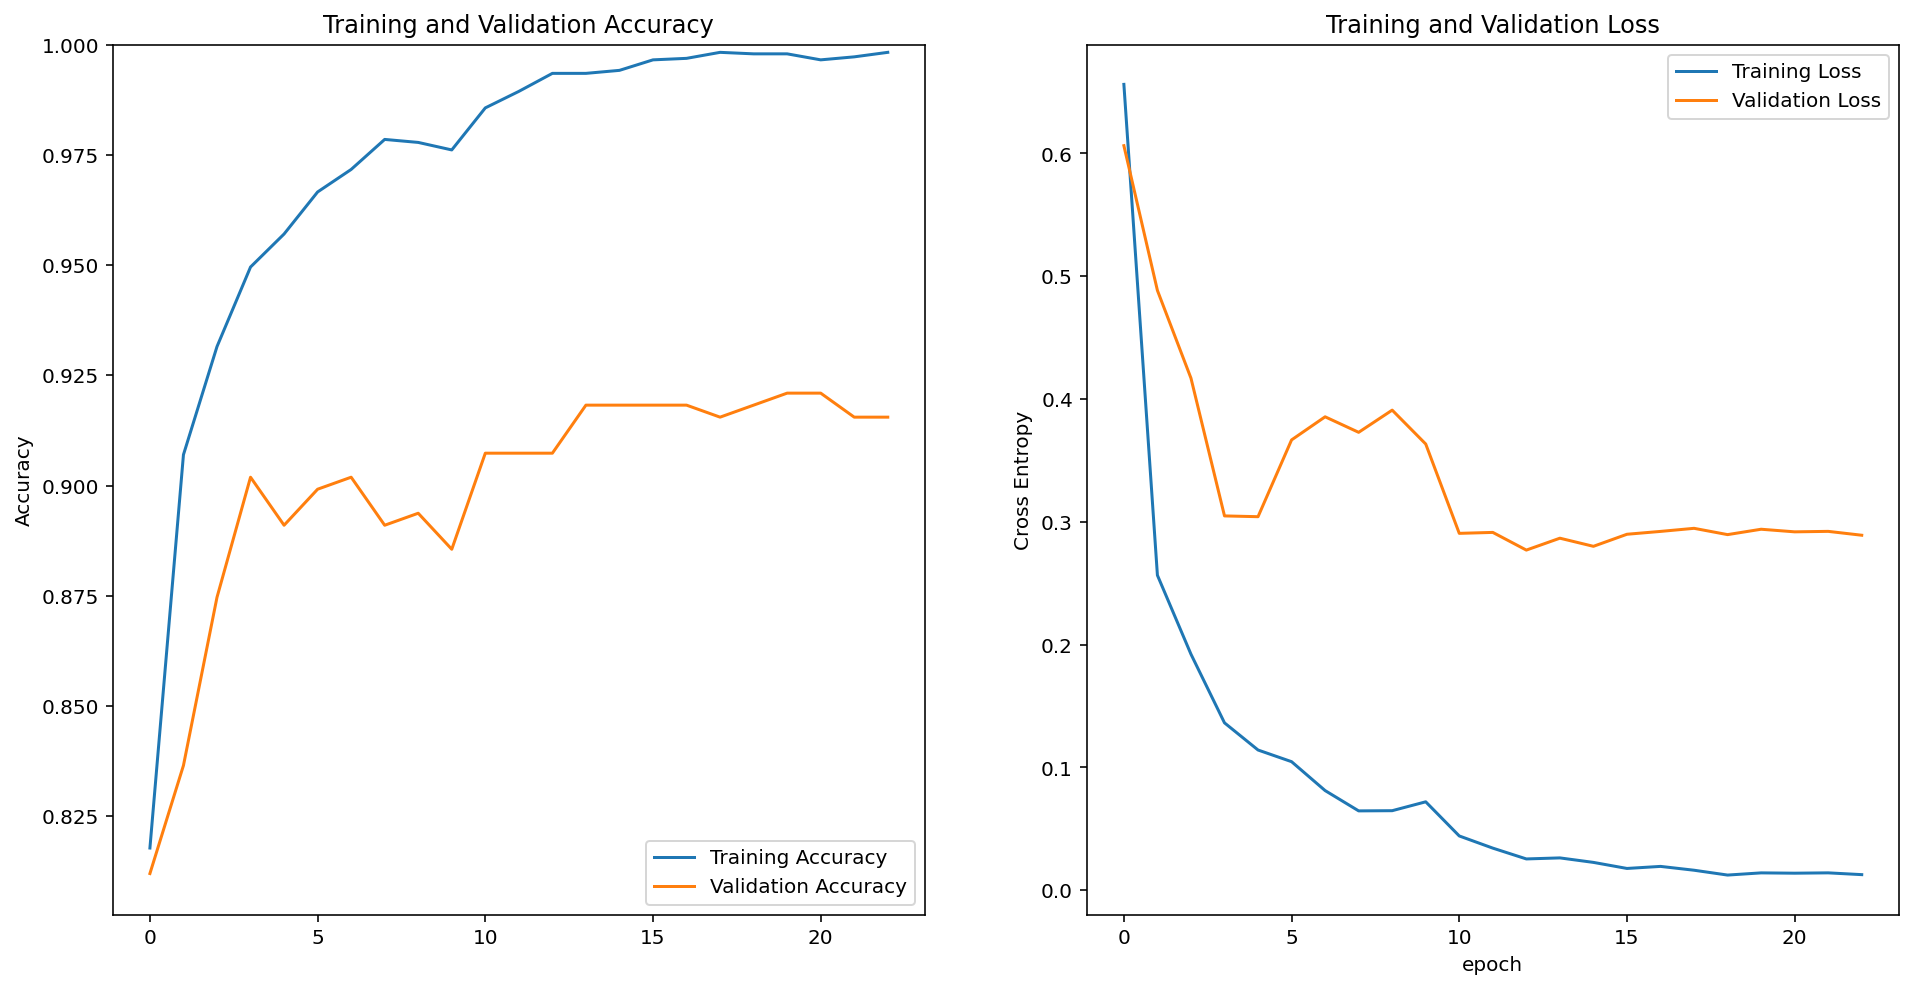

In [9]:
resnet50_acc = resnet50_history.history['accuracy']
resnet50_val_acc = resnet50_history.history['val_accuracy']

resnet50_loss = resnet50_history.history['loss']
resnet50_val_loss = resnet50_history.history['val_loss']

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(resnet50_acc, label='Training Accuracy')
plt.plot(resnet50_val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(resnet50_loss, label='Training Loss')
plt.plot(resnet50_val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [10]:
resnet50_test_loss, resnet50_test_acc = model.evaluate(test_ds)

6/6 [==============================] - 3s 430ms/step - loss: 0.1783 - accuracy: 0.9346


### VGG16  (Transfer Learning)

In [11]:
# 사전 훈련된 VGG16 모델 로드
input_layer = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
base_model = VGG16(weights='imagenet', include_top=False, input_tensor=input_layer)

# 모델의 모든 층을 학습 불가능하게 설정
for layer in base_model.layers:
    layer.trainable = False

# 추가 층 정의 및 모델 구성
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x) 
x = Dropout(0.5)(x) 
predictions = Dense(5, activation='softmax')(x)
model = Model(inputs=input_layer, outputs=predictions)

# 모델 컴파일
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Callbacks 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, min_lr=0.0001)

# 모델 훈련
EPOCHS = 50
vgg16_history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=[early_stopping, model_checkpoint, reduce_lr])

Epoch 1/50
46/46 [==============================] - 92s 2s/step - loss: 0.7704 - accuracy: 0.7643 - val_loss: 0.7838 - val_accuracy: 0.8202

Epoch 00001: val_loss improved from inf to 0.78381, saving model to best_model.h5
Epoch 2/50
46/46 [==============================] - 32s 706ms/step - loss: 0.4082 - accuracy: 0.8665 - val_loss: 0.5394 - val_accuracy: 0.8420

Epoch 00002: val_loss improved from 0.78381 to 0.53938, saving model to best_model.h5
Epoch 3/50
46/46 [==============================] - 33s 708ms/step - loss: 0.3002 - accuracy: 0.8934 - val_loss: 0.3806 - val_accuracy: 0.8774

Epoch 00003: val_loss improved from 0.53938 to 0.38062, saving model to best_model.h5
Epoch 4/50
46/46 [==============================] - 32s 706ms/step - loss: 0.2497 - accuracy: 0.9074 - val_loss: 0.3264 - val_accuracy: 0.8828

Epoch 00004: val_loss improved from 0.38062 to 0.32636, saving model to best_model.h5
Epoch 5/50
46/46 [==============================] - 33s 709ms/step - loss: 0.2329 - acc

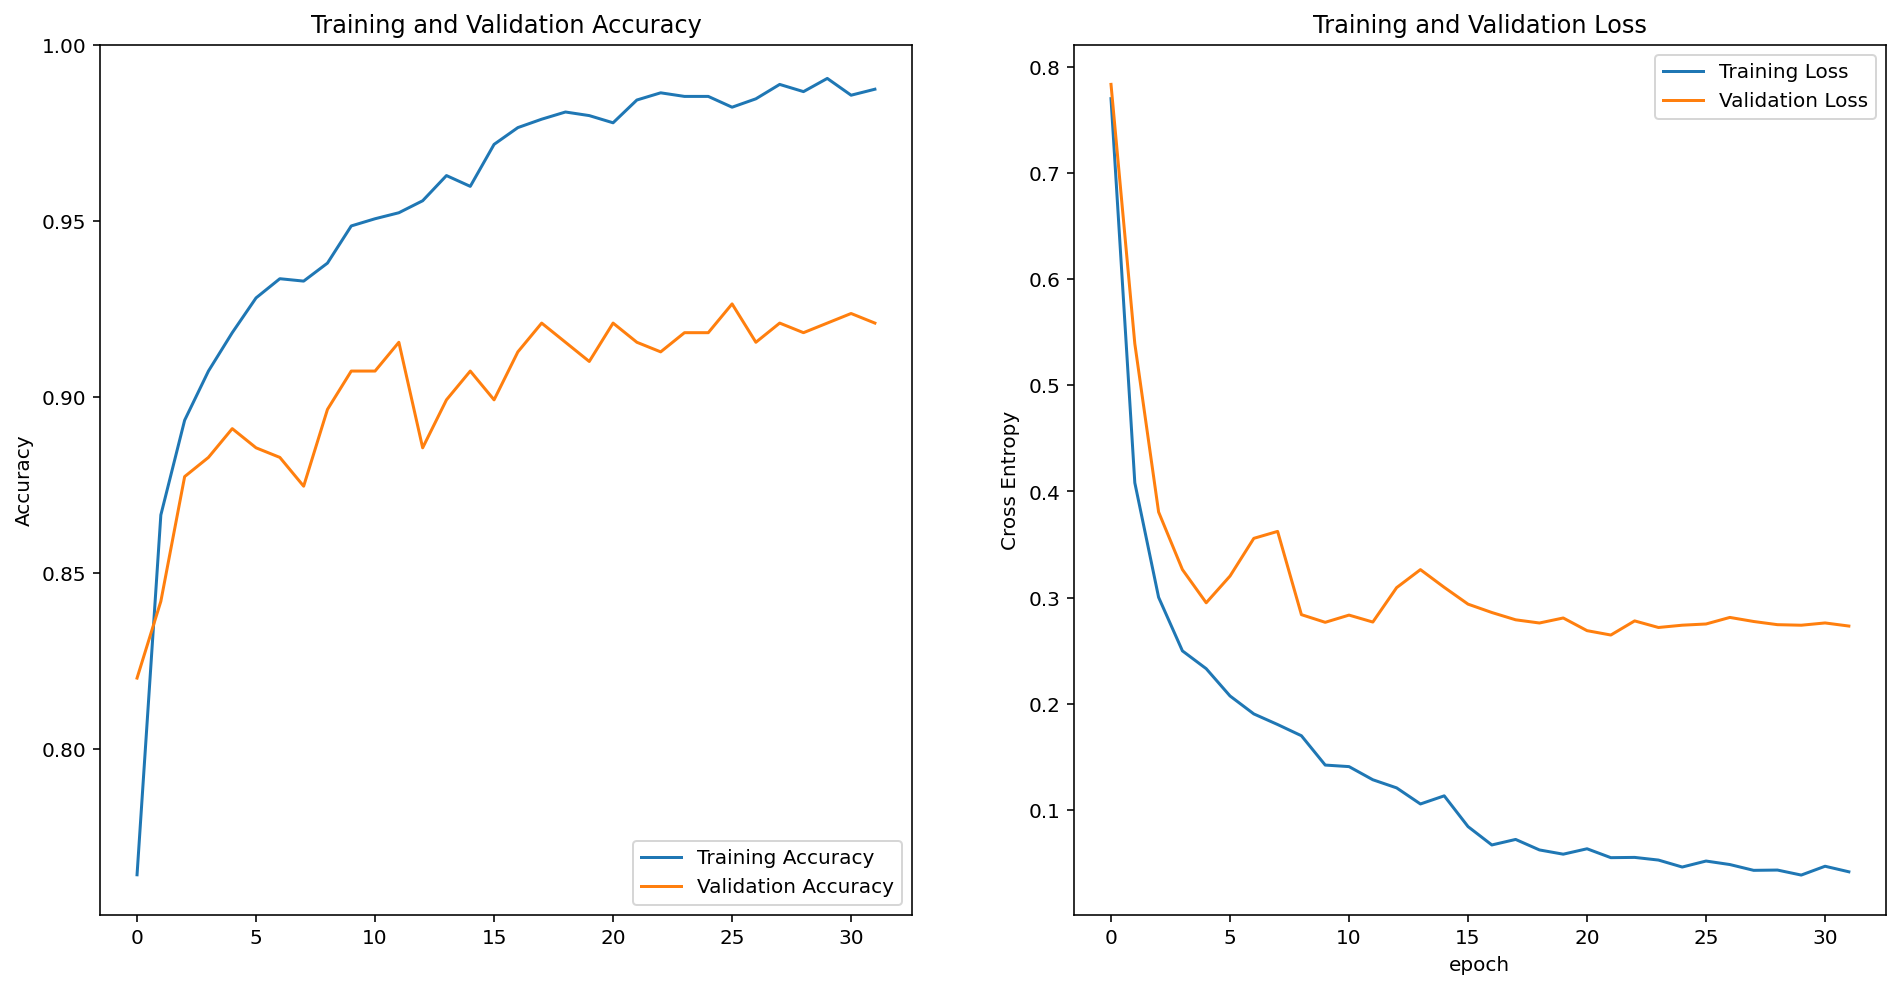

In [12]:
vgg16_acc = vgg16_history.history['accuracy']
vgg16_val_acc = vgg16_history.history['val_accuracy']

vgg16_loss = vgg16_history.history['loss']
vgg16_val_loss = vgg16_history.history['val_loss']

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(vgg16_acc, label='Training Accuracy')
plt.plot(vgg16_val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(vgg16_loss, label='Training Loss')
plt.plot(vgg16_val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [13]:
vgg16_test_loss, vgg16_test_acc = model.evaluate(test_ds)

6/6 [==============================] - 4s 600ms/step - loss: 0.2610 - accuracy: 0.9155


# Retrospective

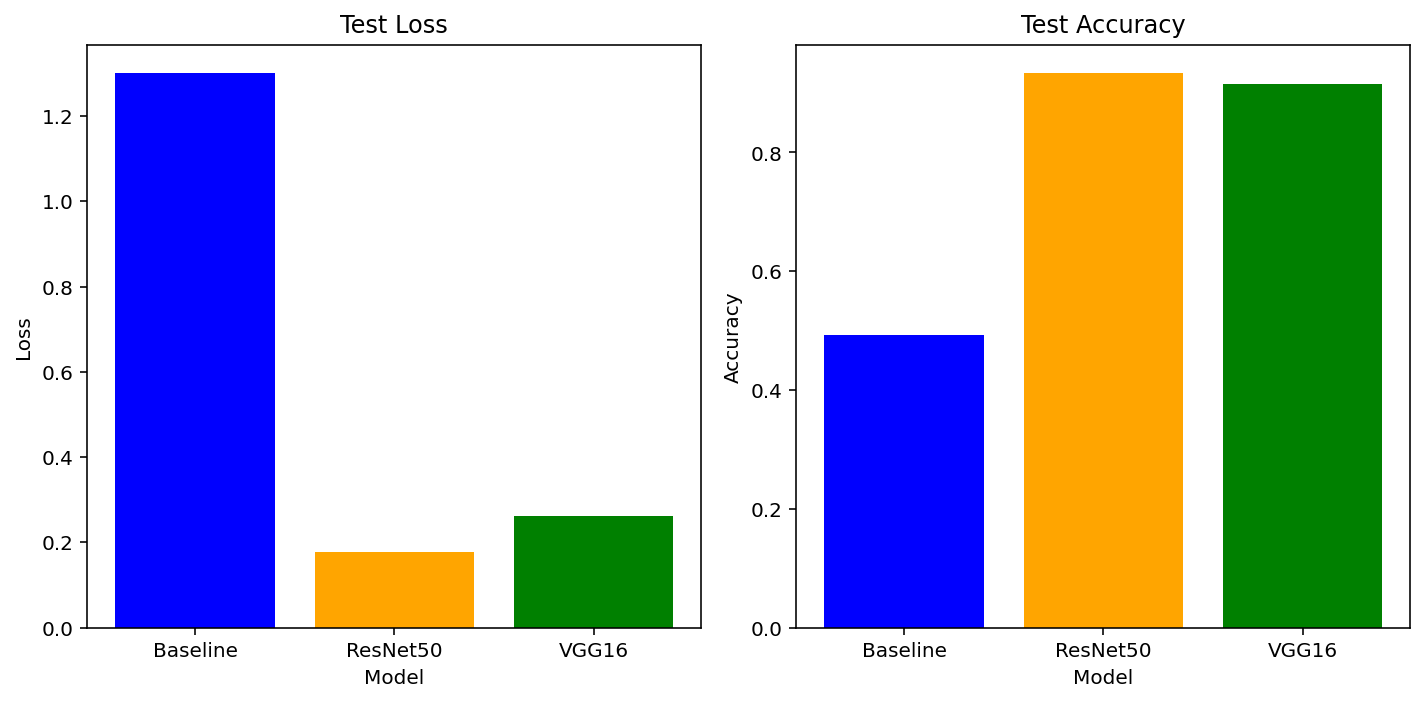

In [14]:
# 평가 결과 데이터
models = ['Baseline', 'ResNet50', 'VGG16']
test_loss = [baseline_test_loss, resnet50_test_loss, vgg16_test_loss]
test_acc = [baseline_test_acc, resnet50_test_acc, vgg16_test_acc]

# 손실 그래프
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(models, test_loss, color=['blue', 'orange', 'green'])
plt.title('Test Loss')
plt.ylabel('Loss')
plt.xlabel('Model')

# 정확도 그래프
plt.subplot(1, 2, 2)
plt.bar(models, test_acc, color=['blue', 'orange', 'green'])
plt.title('Test Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Model')

plt.tight_layout()
plt.show()

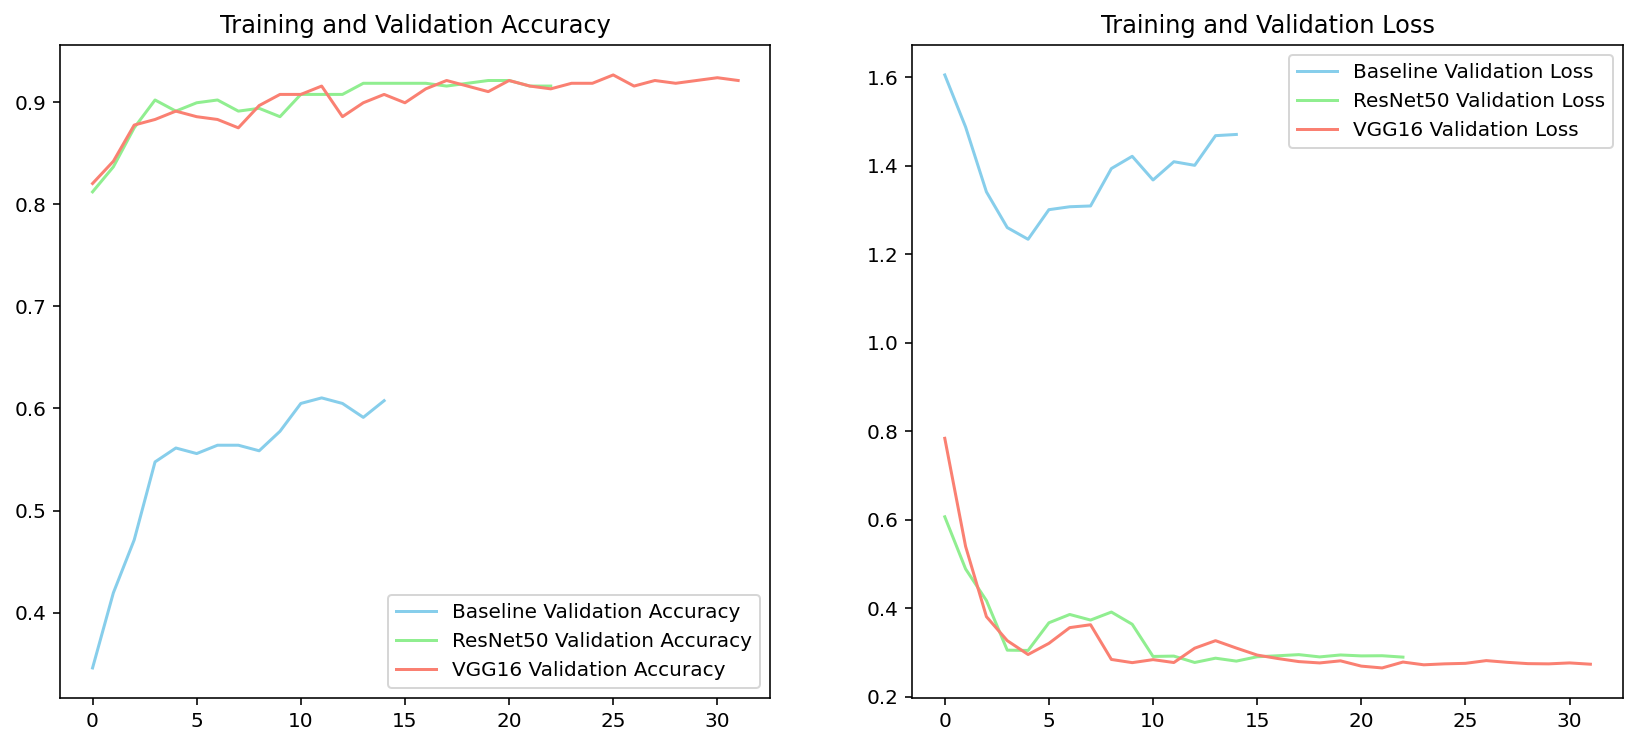

In [16]:
# Accuracy plots with different line colors for better visibility
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(baseline_val_acc, label='Baseline Validation Accuracy', color='skyblue')
plt.plot(resnet50_val_acc, label='ResNet50 Validation Accuracy', color='lightgreen')
plt.plot(vgg16_val_acc, label='VGG16 Validation Accuracy', color='salmon')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Loss plots with different line colors for better visibility
plt.subplot(1, 2, 2)
plt.plot(baseline_val_loss, label='Baseline Validation Loss', color='skyblue')
plt.plot(resnet50_val_loss, label='ResNet50 Validation Loss', color='lightgreen')
plt.plot(vgg16_val_loss, label='VGG16 Validation Loss', color='salmon')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### 성능
1. ResNet50
2. VGG16
3. Baseline

ResNet50 와 VGG16 모두 acc가 0.90가 넘어가며 loss 감소폭이 불안정해지며 학습이 되지 못하고 있는 모습을 보여주고 있다.
데이터 증강을 적용했지만 데이터의 크기가 작은 데이터셋이다보니 데이터가 더 크면 높은 점수대를 만들지 못해 아쉬웠다.

가장 오래 시간이 걸렸던 부분은 Rescaling을 적용했을 때 오히려 loss가 증가하고 acc가 0.3을 넘지 못하는 문제가 있었는데,
모델 내 Rescaling layer를 추가하는 것과 전처리에서 Rescaling을 하는 것의 성능차이가 있었다.

GPT는 동일한 성능을 낼 것이라고하여 정확한 원인은 찾지 못했지만 오랜 시행착오를 통해
전처리 시 Rescaling 외에도 cache는 데이터셋에서 무작위로 데이터를 선택하기 때문에 shuffle은 cache 이후에 사용되어야 하는 등 적용하는 순서와 위치가 성능에 영향을 미치는 요소라는 것을 배웠다.
